In [1]:
from collections import namedtuple
from konlpy.tag import Twitter
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import nltk
import pandas as pd
import pickle
import random as rd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook

In [3]:
font_fname = 'C:/Windows/Fonts/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
date='181024'

In [14]:
# 동적 변수 생성
# 크롤링 결과 로드
for i in range(1,6):
    globals()['rank'+str(i)] = pd.read_csv('output/{}_final_rank{}_app_reviews.csv'.format(date, i), 
                                           names=['user', 'rate', 'date', 'review']) 
    globals()['rank'+str(i)]['rank'] = i
    cn = len(globals()['rank'+str(i)])
    print('{}위 앱 리뷰는 {}건이 있습니다.'.format(i, cn))

1위 앱 리뷰는 8080건이 있습니다.
2위 앱 리뷰는 8080건이 있습니다.
3위 앱 리뷰는 8080건이 있습니다.
4위 앱 리뷰는 8080건이 있습니다.
5위 앱 리뷰는 8080건이 있습니다.


In [15]:
# 데이터 병합
data = pd.concat([rank1, rank2, rank3, rank4, rank5])

# 중복을 제거한 병합
#data = pd.concat([rank1, rank2, rank3, rank4, rank5]).drop_duplicates(['user', 'rate', 'date', 'review'])

In [16]:
# 데이터 정제
# 날짜형 변경
def add_zero(date):
    year, month, day = date[:-1].split('.')
    if len(month) == 1:
        month = '0'+month
    if len(day) == 1:
        day = '0'+day
    return '.'.join([year, month, day])

data['date'] = pd.to_datetime(data['date'].apply(add_zero), format='%Y.%m.%d')

In [17]:
# 가장 빠른 날짜부터 리뷰 마지막 날까지 구간 생성
dt_range = pd.date_range(start=min(data['date']), end=max(data['date']))
dt_list = dt_range.strftime('%Y-%m-%d').tolist()

In [18]:
# 날짜 구간에 공백이 있나 확인
len(dt_list) == len(set(data['date']))

True

In [19]:
# 리뷰 중 가장 많은 건수 추출
result = 0
rank = 0
for i in range(1,6):    
    target = max(data[data['rank']==i].loc[:,['date','review']].groupby(by='date').count().review)
    if result < target:
        result = target
        rank = i
print('가장 많은 리뷰 건수는 {}위 앱의 {} 건'.format(rank, result))

가장 많은 리뷰 건수는 1위 앱의 684 건


In [20]:
# 각 리뷰의 시작일 확인
for i in range(1,6):
    print('{}등 앱 리뷰 시작일은 {} 입니다'.format(i, min(data[data['rank']==i]['date'])))

1등 앱 리뷰 시작일은 2017-11-29 00:00:00 입니다
2등 앱 리뷰 시작일은 2018-06-07 00:00:00 입니다
3등 앱 리뷰 시작일은 2018-07-13 00:00:00 입니다
4등 앱 리뷰 시작일은 2018-09-07 00:00:00 입니다
5등 앱 리뷰 시작일은 2017-10-29 00:00:00 입니다


C:\Users\stu\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


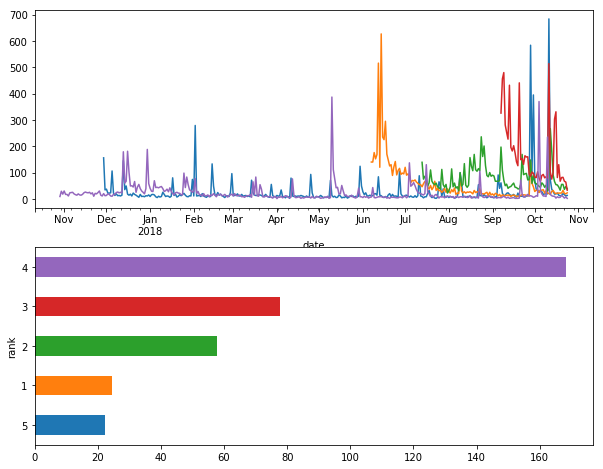

In [30]:
# 그래프를 한번에 그리기
## 날짜, 랭킹, 리뷰수를 담은 임시 데이터프레임 생성
for i in range(1, 6):
    globals()['temp'+str(i)] = data[data['rank']==i].loc[:,['date','rate']].groupby(by='date').count().sort_index()
    globals()['temp'+str(i)]['rank'] = i
date_count = pd.concat([temp1, temp2, temp3, temp4, temp5])
date_count = date_count.reset_index()

## 데이터프레임을 바탕으로 그래프 생성
fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
date_count.groupby('rank').plot(x='date', y='rate', ax=ax1, legend=False)
date_count.groupby('rank')['rate'].mean().sort_values().plot(kind='barh', ax=ax2)

In [31]:
# 리뷰에 대한 통계 요약
date_count[date_count['rank']==5].describe()

,rate,rank
count,360.000000,360.0
mean,22.444444,5.0
std,38.225868,0.0
min,1.000000,5.0
25%,7.000000,5.0
50%,11.000000,5.0
75%,23.000000,5.0
max,387.000000,5.0


In [38]:
# 리뷰가 100개 이상 달린 날 확인
for i in range(1, 6):
    print('rank',i)
    print(date_count[(date_count['rank']==i)&(date_count['rate']>=100)][['date', 'rate']],'\n')

rank 1
          date  rate
0   2017-11-29   156
6   2017-12-05   106
14  2017-12-13   145
65  2018-02-02   279
77  2018-02-14   133
182 2018-05-30   124
210 2018-06-27   105
303 2018-09-28   584
305 2018-09-30   395
316 2018-10-11   684 

rank 2
          date  rate
330 2018-06-07   140
331 2018-06-08   140
332 2018-06-09   176
333 2018-06-10   152
334 2018-06-11   169
335 2018-06-12   516
336 2018-06-13   120
337 2018-06-14   627
338 2018-06-15   235
339 2018-06-16   225
340 2018-06-17   295
341 2018-06-18   170
342 2018-06-19   148
343 2018-06-20   125
344 2018-06-21   130
346 2018-06-23   122
347 2018-06-24   142
349 2018-06-26   108
350 2018-06-27   116
354 2018-07-01   120
443 2018-09-28   141 

rank 3
          date  rate
470 2018-07-13   139
476 2018-07-19   110
484 2018-07-27   112
491 2018-08-03   114
497 2018-08-09   100
500 2018-08-12   134
504 2018-08-16   157
505 2018-08-17   124
506 2018-08-18   107
507 2018-08-19   169
508 2018-08-20   111
509 2018-08-21   105
510 2018-

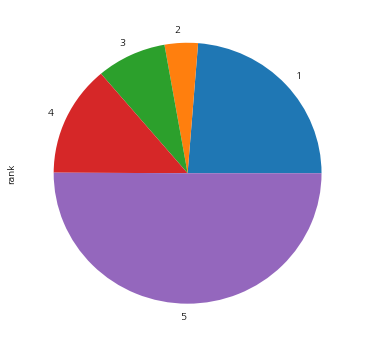

In [169]:
# 전체 구성
plt.figure(figsize=(6, 6))
data.iloc[:,[1,4]].groupby(by='rate').count().loc[:,'rank'].plot(kind='pie')

C:\Users\stu\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


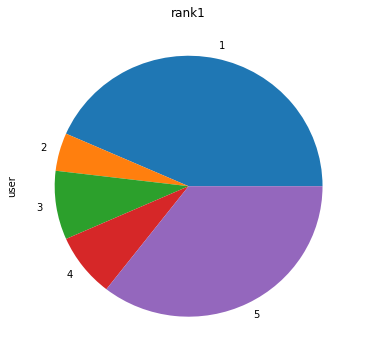

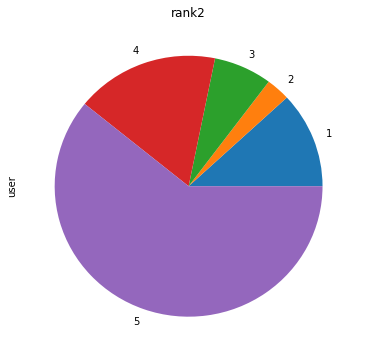

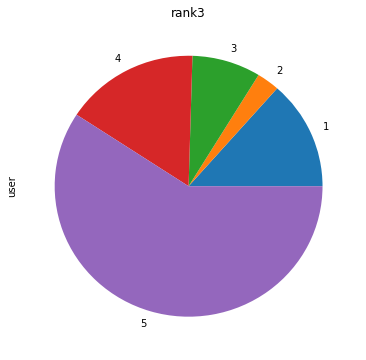

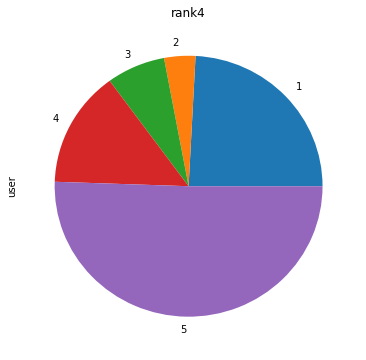

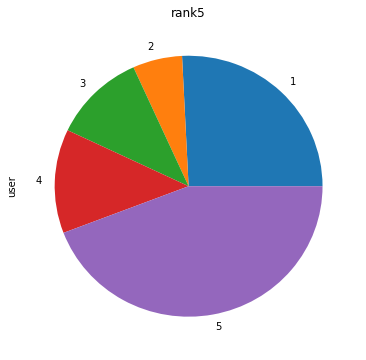

In [41]:
# 개별 별점 파이차트
for i in range(1,6):
    plt.figure(figsize=(6, 6))
    data[data['rank']==i].groupby(by='rate').count().loc[:,'user'].plot(kind='pie', title='rank{}'.format(i))

In [284]:
# 빈 리뷰 비율 확인
for i in range(1,6):
    a,b = data.loc[(data['rank']==i)&(data['user']=='Google 사용자'), ['user', 'review']].count()
    print('{}등 앱의 익명 리뷰 비율: {}'.format(i, (a/8080)*100))
    print('{}등 앱의 익명 빈 리뷰 비율: {}'.format(i, ((b/a)*100)))

1등 앱의 익명 빈 리뷰 비율: 90.78860172299537
2등 앱의 익명 빈 리뷰 비율: 100.0
3등 앱의 익명 빈 리뷰 비율: 100.0
4등 앱의 익명 빈 리뷰 비율: 100.0
5등 앱의 익명 빈 리뷰 비율: 20.193637621023512


In [287]:
len(data)

40400

In [43]:
# 긍정적 리뷰
pos_all = data[((data.rate == 5)|(data.rate == 4))]
len(pos_all)

25777

In [44]:
# 내용이 있는 긍정적 리뷰
pos = data[((data.rate == 5)|(data.rate == 4))&(pd.notnull(data.review))]
len(pos)

21975

In [45]:
# 부정적 리뷰
neg_all = data[((data.rate == 1)|(data.rate == 2))]
len(neg_all)

11219

In [46]:
# 내용이 있는 부정적 리뷰
neg = data[((data.rate == 1)|(data.rate == 2))&(pd.notnull(data.review))]
len(neg)

8590

In [47]:
# 내용이 10자가 넘어가는 긍정적 리뷰
len(pos.loc[pos.review.apply(len) > 10,:])

9091

In [48]:
# 내용이 3자가 넘어가는 긍정적 리뷰
len(pos.loc[pos.review.apply(len) > 3,:])

15590

In [49]:
# 내용이 10자가 넘어가는 부정적 리뷰
len(neg.loc[neg.review.apply(len) > 10,:])

6877

In [50]:
# 내용이 3자가 넘어가는 부정적 리뷰
len(neg.loc[neg.review.apply(len) > 3,:])

8245

In [51]:
# 리뷰가 3자 이상인 리뷰만 사용
pos = pos.loc[pos.review.apply(len) > 3,:]
neg = neg.loc[neg.review.apply(len) > 3,:]

In [52]:
# 모집단에서 랜덤한 8000개씩 추출
positive = pos.iloc[rd.sample(list(pos.index), 8000)]
negative = neg.iloc[rd.sample(list(neg.index), 8000)]

In [53]:
# 라벨 추가
positive['senti'] = 1
negative['senti'] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
# 인덱스 초기화
positive = positive.reset_index().drop(labels='index', axis=1)
negative = negative.reset_index().drop(labels='index', axis=1)

In [55]:
# 6500개는 학습용, 1500개는 테스트용으로 분류
pos_train = positive.iloc[rd.sample(list(positive.index), 6500)]
pos_test = positive.drop(labels=pos_train.index)

neg_train = negative.iloc[rd.sample(list(negative.index), 6500)]
neg_test = negative.drop(labels=neg_train.index)

In [56]:
# 긍정 부정 결합
train_data = pd.concat([pos_train, neg_train])
test_data = pd.concat([pos_test, neg_test])

In [94]:
# 형태소로 토크나이징
tag = Twitter()

def tokenize(doc):
    return ['/'.join(t) for t in tag.pos(doc, norm=True, stem=True)]

train_docs = [[tokenize(row[0]), row[1]] for row in tqdm_notebook(train_data.loc[:, ['review', 'senti']].values.tolist())]
test_docs = [[tokenize(row[0]), row[1]] for row in tqdm_notebook(test_data.loc[:, ['review', 'senti']].values.tolist())]

A Jupyter Widget

A Jupyter Widget

In [99]:
# 결과 저장
with open('output/train.txt', 'wb') as file:
    pickle.dump(train_docs, file)
    
with open('output/test.txt', 'wb') as file:
    pickle.dump(test_docs, file)

In [100]:
# 결과 로드
with open('output/train.txt', 'rb') as file:
    train_docs = pickle.load(file)
    
with open('output/test.txt', 'rb') as file:
    test_docs = pickle.load(file)    

In [105]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d,c in tqdm_notebook(train_docs)]
tagged_test_docs = [TaggedDocument(d, [c]) for d,c in tqdm_notebook(test_docs)]

A Jupyter Widget

A Jupyter Widget

In [110]:
# 사전 구축 및 학습
doc_vectorizer = doc2vec.Doc2Vec(size=300, window=10, min_count=5, workers=11, 
                                 alpha=0.025, min_alpha=0.025, seed=1234, iter=10)
doc_vectorizer.build_vocab(tagged_train_docs)
doc_vectorizer.train(tagged_train_docs, epochs=doc_vectorizer.iter, total_examples=doc_vectorizer.corpus_count)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


In [131]:
doc_vectorizer.wv.most_similar('돈/Noun')

[('빠/Noun', 0.6834322214126587),
 ('사업/Noun', 0.6418277025222778),
 ('놈/Noun', 0.6394428610801697),
 ('밝히다/Verb', 0.6293483972549438),
 ('끌/Noun', 0.6169097423553467),
 ('마오/Noun', 0.6086819767951965),
 ('서민/Noun', 0.6056063175201416),
 ('개념/Noun', 0.6048182249069214),
 ('신경/Noun', 0.6035838723182678),
 ('인식/Noun', 0.6025267243385315)]

In [288]:
doc_vectorizer.wv.most_similar('갓겜/Noun')

[('한국/Noun', 0.810053288936615),
 ('도박장/Noun', 0.7113233804702759),
 ('믿다/Verb', 0.7062156200408936),
 ('차라리/Noun', 0.7018823027610779),
 ('물이/Noun', 0.6959010362625122),
 ('소문/Noun', 0.6924320459365845),
 ('결과/Noun', 0.6821771264076233),
 ('사가/Noun', 0.6820653080940247),
 ('희망/Noun', 0.6810832619667053),
 ('마냥/Noun', 0.6756173968315125)]

In [129]:
doc_vectorizer.wv.most_similar('리니지/Noun')

[('온라인/Noun', 0.7410752773284912),
 ('피씨/Noun', 0.7385654449462891),
 ('M/Alpha', 0.6959742307662964),
 ('PC/Alpha', 0.6730626821517944),
 ('뮤/Noun', 0.6683933734893799),
 ('감회/Noun', 0.6603233814239502),
 ('추억/Noun', 0.6599417924880981),
 ('Rpg/Alpha', 0.6523232460021973),
 ('향수/Noun', 0.6441684365272522),
 ('레볼루션/Noun', 0.6429569125175476)]

In [128]:
doc_vectorizer.wv.most_similar('검사/Noun')

[('감회/Noun', 0.8279738426208496),
 ('예전/Noun', 0.808416485786438),
 ('온라인/Noun', 0.7727009057998657),
 ('오랜만/Noun', 0.7567682862281799),
 ('PC/Alpha', 0.7349396347999573),
 ('반갑다/Adjective', 0.7301114201545715),
 ('오늘아침/Noun', 0.7298837900161743),
 ('추억/Noun', 0.727573037147522),
 ('리지/Noun', 0.7202915549278259),
 ('Pc/Alpha', 0.711399257183075)]

In [127]:
doc_vectorizer.wv.most_similar('뮤/Noun')

[('오리진/Noun', 0.8766986131668091),
 ('온라인/Noun', 0.7523660063743591),
 ('반갑다/Adjective', 0.7500232458114624),
 ('Rpg/Alpha', 0.7448617815971375),
 ('감회/Noun', 0.7252299785614014),
 ('기억/Noun', 0.7165665626525879),
 ('PC/Alpha', 0.7124767303466797),
 ('보다는/Josa', 0.7086739540100098),
 ('검사/Noun', 0.7042219638824463),
 ('향수/Noun', 0.6838489770889282)]

In [126]:
doc_vectorizer.wv.most_similar('에픽/Noun')

[('세븐/Noun', 0.8639975190162659),
 ('대요/Noun', 0.7472425699234009),
 ('웬만하다/Adjective', 0.7171928882598877),
 ('쯤/Suffix', 0.6996524930000305),
 ('성만/Noun', 0.6984156370162964),
 ('업글/Noun', 0.6839733123779297),
 ('토/Noun', 0.6759498119354248),
 ('숫자/Noun', 0.6673101782798767),
 ('또는/Adverb', 0.6664128303527832),
 ('갈아/Adverb', 0.6573964953422546)]

In [123]:
doc_vectorizer.most_similar('세븐/Noun')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('에픽/Noun', 0.8639974594116211),
 ('쯤/Suffix', 0.7439103126525879),
 ('또는/Adverb', 0.7052289247512817),
 ('웬만하다/Adjective', 0.7036557197570801),
 ('대요/Noun', 0.6790307760238647),
 ('하/Noun', 0.6651545166969299),
 ('세다/Verb', 0.6643467545509338),
 ('적어도/Adverb', 0.6439365744590759),
 ('토/Noun', 0.6431447267532349),
 ('나이트/Noun', 0.6412417888641357)]

In [125]:
doc_vectorizer.wv.most_similar('레볼루션/Noun')

[('솔직하다/Adjective', 0.7686430215835571),
 ('PC/Alpha', 0.7640501260757446),
 ('도/Noun', 0.7629796266555786),
 ('따라하다/Verb', 0.7315212488174438),
 ('린/Noun', 0.721646785736084),
 ('페그오/Noun', 0.7178130149841309),
 ('명작/Noun', 0.7142269015312195),
 ('존망/Noun', 0.7058771848678589),
 ('M/Alpha', 0.7028286457061768),
 ('빠찡꼬/Noun', 0.7011435031890869)]

In [134]:
doc_vectorizer.wv.most_similar(positive=['넥슨/Noun'], negative=['돈/Noun'])

[('PC/Alpha', 0.6210565567016602),
 ('환상/Noun', 0.5915484428405762),
 ('pc/Alpha', 0.5914309024810791),
 ('으로써/Josa', 0.576308012008667),
 ('탈/Noun', 0.5734082460403442),
 ('그림/Noun', 0.5602186918258667),
 ('파이팅/Noun', 0.54998379945755),
 ('비슷하다/Adjective', 0.549514889717102),
 ('웹게임/Noun', 0.5465871691703796),
 ('다크/Noun', 0.5461670160293579)]

In [135]:
doc_vectorizer.wv.most_similar(positive=['리니지/Noun'], negative=['돈/Noun'])

[('그대로/Noun', 0.6543329954147339),
 ('PC/Alpha', 0.5502516031265259),
 ('검사/Noun', 0.5497031211853027),
 ('예전/Noun', 0.5231783390045166),
 ('피씨/Noun', 0.5215058326721191),
 ('온라인/Noun', 0.5121940970420837),
 ('뮤/Noun', 0.4963580369949341),
 ('시절/Noun', 0.47585803270339966),
 ('오크/Noun', 0.47422707080841064),
 ('M/Alpha', 0.47253328561782837)]

In [136]:
doc_vectorizer.wv.most_similar(positive=['검사/Noun','돈/Noun'])

[('추억/Noun', 0.6927680969238281),
 ('나중/Noun', 0.6647011637687683),
 ('김택진/Noun', 0.6617103815078735),
 ('리지/Noun', 0.6517782211303711),
 ('새록새록/Noun', 0.6504569053649902),
 ('웹/Noun', 0.646432101726532),
 ('오랜만/Noun', 0.6396712064743042),
 ('탓/Noun', 0.6389440894126892),
 ('감회/Noun', 0.637906551361084),
 ('기대/Noun', 0.6358985900878906)]

In [145]:
doc_vectorizer.wv.most_similar(positive=['리니지/Noun','재미/Noun'])

[('감회/Noun', 0.7586852312088013),
 ('향수/Noun', 0.7379505038261414),
 ('Rpg/Alpha', 0.7275543212890625),
 ('온라인/Noun', 0.7065575122833252),
 ('피시/Noun', 0.7005727887153625),
 ('당/Noun', 0.6664420962333679),
 ('시절/Noun', 0.6663623452186584),
 ('피씨/Noun', 0.6656876802444458),
 ('보다는/Josa', 0.6654574871063232),
 ('추억/Noun', 0.6630070805549622)]

In [290]:
doc_vectorizer.wv.most_similar(positive=['갓겜/Noun', '돈/Noun'])

[('엔씨/Noun', 0.7635743618011475),
 ('마오/Noun', 0.7581894397735596),
 ('서민/Noun', 0.7579282522201538),
 ('사회/Noun', 0.7444549798965454),
 ('사업/Noun', 0.7338839769363403),
 ('물이/Noun', 0.7284243106842041),
 ('nc/Alpha', 0.7247437238693237),
 ('사가/Noun', 0.7173272967338562),
 ('회사/Noun', 0.7169128656387329),
 ('돈빨/Noun', 0.7044629454612732)]

In [292]:
doc_vectorizer.wv.most_similar(positive=['갓겜/Noun'],negative=['돈/Noun'])

[("'/Punctuation", 0.5618014335632324),
 ('모바일/Noun', 0.5529162883758545),
 ('도박장/Noun', 0.5041584968566895),
 ('Pc/Alpha', 0.45175641775131226),
 ('검사/Noun', 0.4498326778411865),
 ('우정/Noun', 0.4491449296474457),
 ('그대로/Noun', 0.4478108286857605),
 ('와우/Noun', 0.44741547107696533),
 ('검다/Adjective', 0.44718214869499207),
 ('금지/Noun', 0.44665640592575073)]

In [138]:
# 분류를 위한 피쳐 생성
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tqdm_notebook(tagged_train_docs)]
train_y = [doc.tags[0] for doc in tqdm_notebook(tagged_train_docs)]

A Jupyter Widget

A Jupyter Widget

In [141]:
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tqdm_notebook(tagged_test_docs)]
test_y = [doc.tags[0] for doc in tqdm_notebook(tagged_test_docs)]

A Jupyter Widget

A Jupyter Widget

In [295]:
classifier = LogisticRegression(random_state=4321)
classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)

0.69866666666666666